# Unusual Large Jumps (QAQC)

In [1]:
# Import libraries
import pandas as pd
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import matplotlib as mpl
import glob
import datetime as dt
import scipy
%matplotlib inline
%load_ext autoreload
%autoreload 2

## ML to fit annual cycle

<div style="display: flex;">
    <span style="width: 59%"><p size="+2.75">We need to remove the seasonal signal from the data to be able to look for unusual spikes in the data.</p></span> 
</div>
<br>
<img src="Seasonal.png" width="500" height="500">
<div style="display: flex;">
    <span style="width: 59%"><p size="+2.75">One way would be to fit annual and seasonal harmonic and remove it from the original series.</p></span> 
</div>


In [2]:
from sklearn.linear_model import SGDRegressor
from sklearn.utils.fixes import parse_version, sp_version
from sklearn.pipeline import FeatureUnion
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.pipeline import Pipeline
from sklearn import base

class FourierComponents(base.BaseEstimator, base.TransformerMixin):
    
    def __init__(self, freq):
        self.freq = freq
    
    def fit(self, X, y=None):
        self.X0 = X[0]
        return self
    
    def transform(self, X):
        dt = (X - self.X0).values.astype("float")/1e9
        dt = dt * 2 * np.pi * self.freq
        return np.c_[np.sin(dt), np.cos(dt)]

f_d = 1/(3600)
f_s = 1/(365*24*4*3600)
f_y = 1/(365*24*3600)

union = FeatureUnion([
                      ('fourier_annual', FourierComponents(f_y)),
                      ('fourier_seasonal', FourierComponents(f_s)),
                      # ('fourier_daily', FourierComponents(f_d)),
                    ])
model_drift_fourier = Pipeline([('union', union),
                                ('regressor', LinearRegression())])

class FullModel(base.BaseEstimator, base.RegressorMixin):
    def __init__(self):
        """Combine a baseline and residual model to predict any number of steps in the future."""
        
        self.baseline = model_drift_fourier
        self.residual_model = LinearRegression()
        
    def fit(self, X, y):
        self.baseline.fit(X.index, X[var])
        resd = X[var] - self.baseline.predict(X.index)
        self.residual_model.fit(X.index.values.astype("float").reshape(-1,1), resd) 
        # self.residual_model.fit(X.index, resd) 
        return self
    
    def predict(self, X):
        y_b = self.baseline.predict(X.index)
        y_r = self.residual_model.predict(X.index.values.astype("float").reshape(-1,1),)
        plt.plot(y_r)
        y_pred = y_b + y_r
        
        return y_pred

class ResidualFeatures(base.BaseEstimator, base.TransformerMixin):
    def __init__(self, window=20):
        """Generate features based on window statistics of past noise/residuals."""
        self.window = window
        
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        df = pd.DataFrame()
        df['residual'] = pd.Series(X, index=X.index)
        df['prior'] = df['residual'].shift(1)
        df['mean'] = df['residual'].rolling(window=self.window, min_periods=0).mean()
        df['diff'] = df['residual'].diff().rolling(window=self.window).mean()
        df = df.fillna(method='bfill')
        return df

In [3]:
ds = xr.open_dataset('train_files/SNOTEL_835.nc').isel(station=0)
ds

<xarray.Dataset>
Dimensions:    (time: 149896)
Coordinates:
  * time       (time) datetime64[ns] 1980-01-01T08:00:00 ... 2022-08-31T23:00:00
    station    <U10 'SNOTEL_835'
    lat        (time) float64 ...
    lon        (time) float64 ...
Data variables:
    tas        (time) float64 ...
    pr         (time) float64 ...
    tas_qc     (time) object ...
    pr_qc      (time) object ...
    elevation  (time) float64 ...
Attributes: (12/17)
    title:                 SNOTEL cleaned
    institution:           Eagle Rock Analytics / Cal Adapt
    source:                
    history:               SCANSNOTEL_clean.py script run on 02-16-2023, 23:3...
    comment:               Intermediate data product: may not have been subje...
    license:               
    ...                    ...
    station_name:          Twelvemile Creek
    subnetwork:            SNOTEL
    huc:                   170102050601
    hud:                   17010205
    shefId:                TMCM8
    raw_files_merged:      1

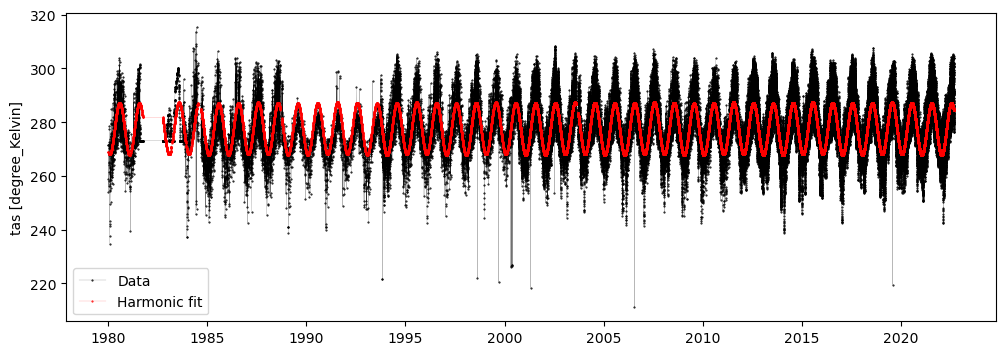

In [4]:
var = 'tas'
# var = 'hurs'
df = ds[var].to_dataframe().dropna(subset=var).drop(columns=["lat","lon"])#.reset_index()

model = model_drift_fourier
model.fit(df.index, df[var])
y_base = model.predict(df.index)

DAYS_INTO_FUTURE = 3
train_noise = df[var]-y_base

# create and train residual model
residual_model = Pipeline([('residual_features', ResidualFeatures(window=10)), 
                           ('regressor', SGDRegressor())])
residual_model.fit(train_noise.iloc[:-DAYS_INTO_FUTURE], 
                   train_noise.shift(-DAYS_INTO_FUTURE).dropna())

y_res = residual_model.predict(train_noise)

y_fit = y_base + y_res*0.

fig,ax = plt.subplots(figsize=(12,4))
ax.plot(df.index, df[var], '.-', lw=0.1, ms=1, color="k", label="Data")
ax.plot(df.index, y_fit, '.-', lw=0.1, ms=1, color="r", label="Harmonic fit")
# ax.set_title("{:.4f}".format(len(np.where(ind)[0])/len(df.index)))
ax.legend()
ax.set_ylabel("{} [{}]".format(var, ds[var].attrs['units']))
df['y_fit'] = y_fit

## HadISD method

<div style="display: flex;">
    <span style="width: 59%"><p size="+2.75">To be consistent with HadISD methodology, we will avoid the harmonic fitting. Instead, we do an analysis per month in the data, this way we avoid seasonal signal from strongly seasonal stations.</p></span> 
</div>
<br>
<img src="HadISD1.png" width="500" height="500">
<div style="display: flex;">
    <span style="width: 59%"><p size="+2.75">First, we divide the data into months, and calculate the time difference between data. We limit this to data separated by less than 10 hours.</p></span> 
</div>
<div style="display: flex;">
    <span style="width: 59%"><p size="+2.75">Then, we calculate the differences in the time series, which is the variable to work with.</p></span> 
</div>
<div style="display: flex;">
    <span style="width: 59%"><p size="+2.75">The critical value to select potential spikes is 6 times the IQR of that month's differences.</p></span> 
</div>


### SNOTEL_835

In [5]:
ds = xr.open_dataset('train_files/SNOTEL_835.nc').isel(station=0)
ds

<xarray.Dataset>
Dimensions:    (time: 149896)
Coordinates:
  * time       (time) datetime64[ns] 1980-01-01T08:00:00 ... 2022-08-31T23:00:00
    station    <U10 'SNOTEL_835'
    lat        (time) float64 ...
    lon        (time) float64 ...
Data variables:
    tas        (time) float64 ...
    pr         (time) float64 ...
    tas_qc     (time) object ...
    pr_qc      (time) object ...
    elevation  (time) float64 ...
Attributes: (12/17)
    title:                 SNOTEL cleaned
    institution:           Eagle Rock Analytics / Cal Adapt
    source:                
    history:               SCANSNOTEL_clean.py script run on 02-16-2023, 23:3...
    comment:               Intermediate data product: may not have been subje...
    license:               
    ...                    ...
    station_name:          Twelvemile Creek
    subnetwork:            SNOTEL
    huc:                   170102050601
    hud:                   17010205
    shefId:                TMCM8
    raw_files_merged:      1

In [6]:
df = ds[var].to_dataframe().dropna(subset=var).drop(columns=["lat","lon"])#.reset_index()

In [7]:
# df['abs_difference'] = np.abs(df[var].diff().fillna(0))
df['difference'] = df[var].diff().fillna(0)
# df['difference'] = (df[var]-df['y_fit']).diff().fillna(0)
df['date'] = df.index.values
df['time_diff'] = df['date'].diff().fillna(pd.Timedelta(0))
df['hours_diff'] = df['time_diff']/np.timedelta64(1, 'h')
dfbk = df.copy(deep=True)
df = df[np.logical_and(df['hours_diff'] >= 1, df['hours_diff'] <= 12)]
df

,station,tas,difference,date,time_diff,hours_diff
time,,,,,,
1980-01-04 22:00:00,SNOTEL_835,271.650000,12.888889,1980-01-04 22:00:00,0 days 10:00:00,10.0
1980-01-17 21:00:00,SNOTEL_835,270.372222,-1.500000,1980-01-17 21:00:00,0 days 09:00:00,9.0
1980-01-18 21:00:00,SNOTEL_835,264.650000,0.500000,1980-01-18 21:00:00,0 days 09:00:00,9.0
1980-01-21 21:00:00,SNOTEL_835,272.427778,4.500000,1980-01-21 21:00:00,0 days 07:00:00,7.0
1980-01-24 22:00:00,SNOTEL_835,278.372222,1.000000,1980-01-24 22:00:00,0 days 07:00:00,7.0
...,...,...,...,...,...,...
2022-08-31 19:00:00,SNOTEL_835,303.927778,2.500000,2022-08-31 19:00:00,0 days 01:00:00,1.0
2022-08-31 20:00:00,SNOTEL_835,303.872222,-0.055556,2022-08-31 20:00:00,0 days 01:00:00,1.0
2022-08-31 21:00:00,SNOTEL_835,304.538889,0.666667,2022-08-31 21:00:00,0 days 01:00:00,1.0


Text(0, 0.5, 'tas [degree_Kelvin]')

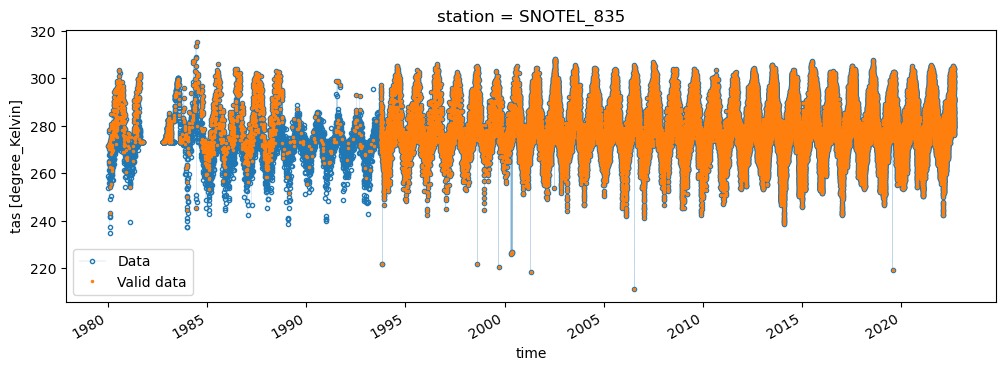

In [8]:
fig,ax = plt.subplots(figsize=(12,4))

ds[var].plot(ax=ax, marker=".", ms=6, lw=.1, mfc='none', label="Data")
df[var].plot(ax=ax, marker=".", ms=3, lw=0, label="Valid data")
ax.legend()
ax.set_ylabel("{} [{}]".format(var, ds[var].attrs['units']))

Text(0, 0.5, 'tas [degree_Kelvin]')

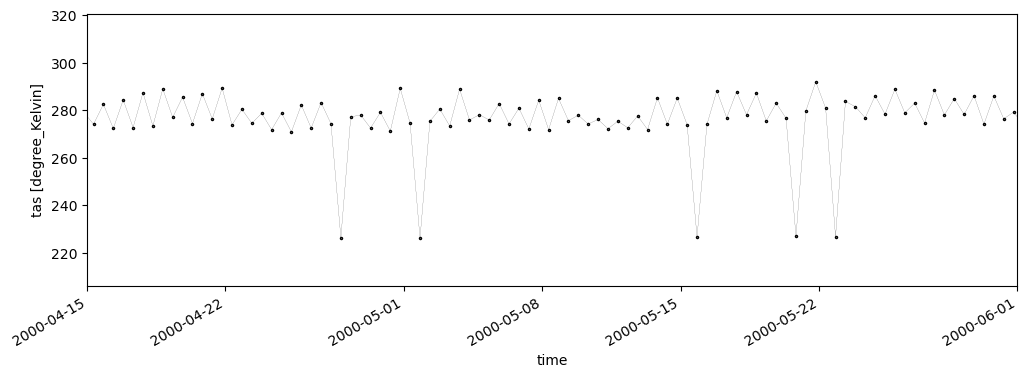

In [9]:
fig,ax = plt.subplots(figsize=(12,4))

(df[var]).plot(ax=ax, marker=".", ms=3, lw=.1, mfc='none', color="k")
ax.set_xlim(np.datetime64("2000-04-15"), np.datetime64("2000-06-01"))
ax.set_ylabel("{} [{}]".format(var, ds[var].attrs['units']))

In [10]:
# grouped = df.groupby([pd.Grouper(freq='M'), df['hours_diff']]) 
grouped = df.groupby(pd.Grouper(freq='M')) 

# grouped = df.groupby([pd.Grouper(freq='Y'), df['hours_diff']]) 
# grouped = df.groupby([pd.Grouper(freq='Y')]) 
# grouped = df.groupby([df['hours_diff']]) 

counts = grouped['difference'].transform("count")

# std = grouped['difference'].transform("median") + grouped['difference'].transform("std")

df['counts'] = counts
df = df[df['counts']>100]

# kwargs = {'rng':(15, 85),
# kwargs = {'rng':(25, 75),
#           'scale':1.0,
#           'nan_policy':'propagate',
#           'interpolation':'linear',
#          }
# kwargs = {'rng':(20, 80),}
kwargs = {}
iqr = grouped['difference'].transform(scipy.stats.iqr, **kwargs)
# abs_iqr = grouped['abs_difference'].transform(scipy.stats.iqr, **kwargs)
df['iqr'] = iqr
# df['abs_iqr'] = abs_iqr
# df['std'] = std

df['critical'] = np.ceil(6*df['iqr'])
# df['abs_critical'] = np.ceil(6*df['abs_iqr'])
df

# df.iloc[-16800:-16750]

/var/folders/dj/qqhqnt2n4993vwmy6qcpnbk80000gn/T/ipykernel_6172/11751727.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['iqr'] = iqr
/var/folders/dj/qqhqnt2n4993vwmy6qcpnbk80000gn/T/ipykernel_6172/11751727.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['critical'] = np.ceil(6*df['iqr'])


,station,tas,difference,date,time_diff,hours_diff,counts,iqr,critical
time,,,,,,,,,
1993-10-01 08:00:00,SNOTEL_835,276.872222,-9.277778,1993-10-01 08:00:00,0 days 06:00:00,6.0,227,3.444444,21.0
1993-10-01 11:00:00,SNOTEL_835,275.261111,-1.611111,1993-10-01 11:00:00,0 days 03:00:00,3.0,227,3.444444,21.0
1993-10-01 14:00:00,SNOTEL_835,274.761111,-0.500000,1993-10-01 14:00:00,0 days 03:00:00,3.0,227,3.444444,21.0
1993-10-01 17:00:00,SNOTEL_835,286.038889,11.277778,1993-10-01 17:00:00,0 days 03:00:00,3.0,227,3.444444,21.0
1993-10-01 20:00:00,SNOTEL_835,287.761111,1.722222,1993-10-01 20:00:00,0 days 03:00:00,3.0,227,3.444444,21.0
...,...,...,...,...,...,...,...,...,...
2022-08-31 19:00:00,SNOTEL_835,303.927778,2.500000,2022-08-31 19:00:00,0 days 01:00:00,1.0,742,2.055556,13.0
2022-08-31 20:00:00,SNOTEL_835,303.872222,-0.055556,2022-08-31 20:00:00,0 days 01:00:00,1.0,742,2.055556,13.0
2022-08-31 21:00:00,SNOTEL_835,304.538889,0.666667,2022-08-31 21:00:00,0 days 01:00:00,1.0,742,2.055556,13.0


In [11]:
df['potential_spike'] = np.abs(df['difference'])>df['critical']
len(np.where(df['potential_spike'])[0])

/var/folders/dj/qqhqnt2n4993vwmy6qcpnbk80000gn/T/ipykernel_6172/3457975501.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['potential_spike'] = np.abs(df['difference'])>df['critical']


422

<AxesSubplot:xlabel='time'>

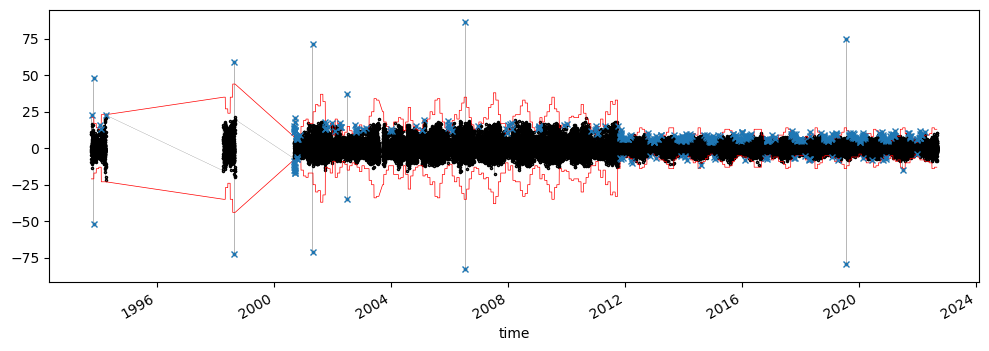

In [12]:
fig,ax = plt.subplots(figsize=(12,4))

(df['difference']).plot(ax=ax, marker=".", ms=3, lw=.1, mfc='none', color="k")
(df['critical']).plot(ax=ax, lw=.5, ls="-", color="red")
(-1*df['critical']).plot(ax=ax, lw=.5, ls="-", color="red")
df['difference'][df['potential_spike']].plot(ax=ax, marker="x", ms=5, lw=0, color="C0")

# fig,ax = plt.subplots(figsize=(12,4))

# (df['abs_difference']).plot(ax=ax, marker=".", ms=2, lw=.1, mfc='none', color="k")
# (df['abs_critical']).plot(ax=ax, lw=.5, color="red")

<AxesSubplot:xlabel='time'>

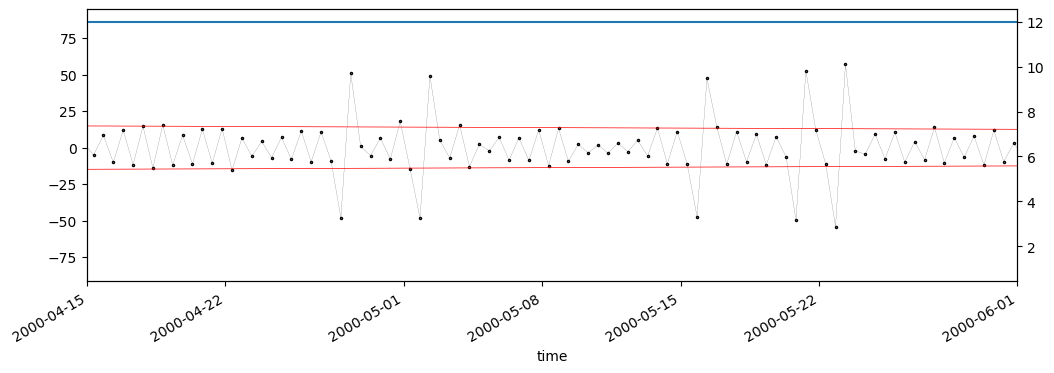

In [13]:
fig,ax = plt.subplots(figsize=(12,4))

(dfbk['difference']).plot(ax=ax, marker=".", ms=3, lw=.1, mfc='none', color="k")
(df['critical']).plot(ax=ax, lw=.5, ls="-", color="red")
(-1*df['critical']).plot(ax=ax, lw=.5, ls="-", color="red")
df['difference'][df['potential_spike']].plot(ax=ax, marker="x", ms=5, lw=0, color="C0")
ax.set_xlim(np.datetime64("2000-04-15"), np.datetime64("2000-06-01"))
axt = ax.twinx()
df['hours_diff'].plot(ax=axt)

<AxesSubplot:xlabel='time'>

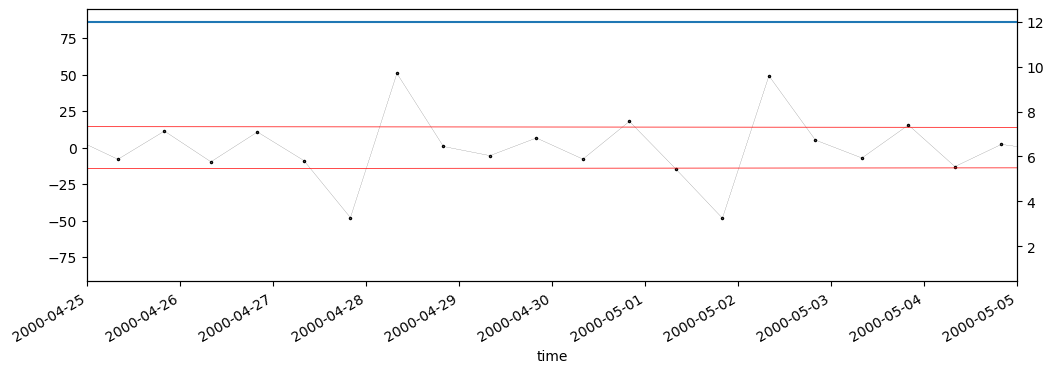

In [14]:
fig,ax = plt.subplots(figsize=(12,4))

(dfbk['difference']).plot(ax=ax, marker=".", ms=3, lw=.1, mfc='none', color="k")
(df['critical']).plot(ax=ax, lw=.5, ls="-", color="red")
(-1*df['critical']).plot(ax=ax, lw=.5, ls="-", color="red")
df['difference'][df['potential_spike']].plot(ax=ax, marker="x", ms=5, lw=0, color="C0")
ax.set_xlim(np.datetime64("2000-04-25"), np.datetime64("2000-05-05"))
axt = ax.twinx()
df['hours_diff'].plot(ax=axt)

In [15]:
def potential_spike_check(potential_spike, diff, crit, hours_diff):
    """
    data is `potential_spike`
    """

    potential_spike = potential_spike.copy(deep=True)
    
    ind = np.where(potential_spike)[0]
    spikes = pd.Series(np.zeros_like(potential_spike).astype("bool"), index=potential_spike.index)
    dates = pd.Series(potential_spike.index.values)
    # print(len(ind))
    # print(dates[ind])
    
    for i in ind:
        
        #Ignore edges for now
        if i==1 or i>=len(potential_spike)-4:
            continue
        # Indices, critical values, and values before and after potential spike
        im1, i0, ip1, ip2, ip3, ip4 = [i-1, i, i+1, i+2, i+3, i+4]
        tm1, t0, tp1, tp2, tp3, tp4 = diff.iloc[[im1, i0, ip1, ip2, ip3, ip4]]
        cm1, c0, cp1, cp2, cp3, cp4 = crit.iloc[[im1, i0, ip1, ip2, ip3, ip4]]
        # print(dates.iloc[[i0,ip1]])
        # print(" sgn(t0)[{}] != sgn(tm1)[{}] \n abs(tm1)[{}] < cm1[{}] \n abs(tp1)[{}] > cp1[{}] \n abs(tp2)[{}] < cp2[{}]".format(np.sign(t0),np.sign(tp1), np.abs(tm1), cm1, np.abs(tp1), cp1, np.abs(tp2), cp2))
        # print()
        # Three-values spike
        if (
            np.sign(t0) != np.sign(tp2) and 
            np.abs(tm1) < 0.5*cm1 and 
            np.abs(tp1) < 0.5*cp1 and 
            np.abs(tp2) < 0.5*cp2 and 
            np.abs(tp3) > cp3 and 
            np.abs(tp4) < 0.5*cp4
        ):
            # print(dates.iloc[i0])
            spikes.iloc[[i0,ip1,ip2]] = True
            # i += 3
            # continue
            
        # Two-values spike
        elif (
            np.sign(t0) != np.sign(tp2) and 
            np.abs(tm1) < 0.5*cm1 and 
            np.abs(tp1) < 0.5*cp1 and 
            np.abs(tp2) > cp2 and 
            np.abs(tp3) < 0.5*cp3
        ):
            # print(dates.iloc[i0])
            spikes.iloc[[i0,ip1]] = True
            # i += 2
            # continue
        
        # One-value spike
        elif( 
            np.sign(t0) != np.sign(tp1) and 
            np.abs(tm1) < 1.0*cm1 and 
            np.abs(tp1) > cp1 and 
            np.abs(tp2) < 1.0*cp2
        ):
            # print(dates.iloc[i0])
            spikes.iloc[i0] = True
            # i += 1
            # continue
        
    return spikes

<div style="display: flex;">
    <span style="width: 59%"><p size="+2.75">The nexts step is to take all potential spikes, and determine which are real spikes. For this, we only account for one, two, and three value-spikes.</p></span> 
</div>
<br>
<img src="HadISD2.png" width="500" height="500">
<div style="display: flex;">
    <span style="width: 59%"><p size="+2.75">The difference before the spike must be less than half the critical value.</p></span> 
</div>
<div style="display: flex;">
    <span style="width: 59%"><p size="+2.75">The spike itself must be higher than the critical difference value.</p></span> 
</div>
<div style="display: flex;">
    <span style="width: 59%"><p size="+2.75">Differences within the multi-value-spike must be less than half the critical value.</p></span> 
</div>
<div style="display: flex;">
    <span style="width: 59%"><p size="+2.75">Finally, the spike exit: The difference after the spike must be of the opposite sign of the actual spike, and be higher in magnitude than the critical value.</p></span> 
</div>

Assuming only up to 3 values spikes are accounted for her, I assume larger spikes should be detected by the distribution (an other) QAQC functions? 

In [16]:
spikes = potential_spike_check(df['potential_spike'], df['difference'], df['critical'], df['hours_diff'])
print(len(np.where(spikes)[0]))
df['spikes'] = spikes
df.head(5)

11


/var/folders/dj/qqhqnt2n4993vwmy6qcpnbk80000gn/T/ipykernel_6172/580060253.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['spikes'] = spikes


,station,tas,difference,date,time_diff,hours_diff,counts,iqr,critical,potential_spike,spikes
time,,,,,,,,,,,
1993-10-01 08:00:00,SNOTEL_835,276.872222,-9.277778,1993-10-01 08:00:00,0 days 06:00:00,6.0,227,3.444444,21.0,False,False
1993-10-01 11:00:00,SNOTEL_835,275.261111,-1.611111,1993-10-01 11:00:00,0 days 03:00:00,3.0,227,3.444444,21.0,False,False
1993-10-01 14:00:00,SNOTEL_835,274.761111,-0.500000,1993-10-01 14:00:00,0 days 03:00:00,3.0,227,3.444444,21.0,False,False
1993-10-01 17:00:00,SNOTEL_835,286.038889,11.277778,1993-10-01 17:00:00,0 days 03:00:00,3.0,227,3.444444,21.0,False,False
1993-10-01 20:00:00,SNOTEL_835,287.761111,1.722222,1993-10-01 20:00:00,0 days 03:00:00,3.0,227,3.444444,21.0,False,False


<AxesSubplot:xlabel='time'>

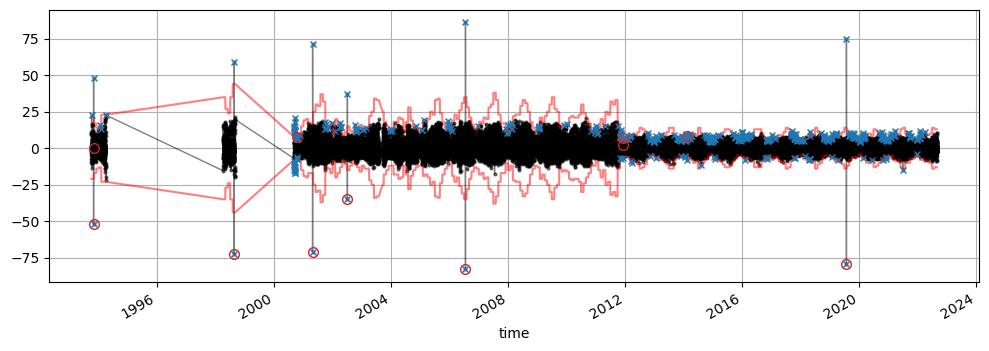

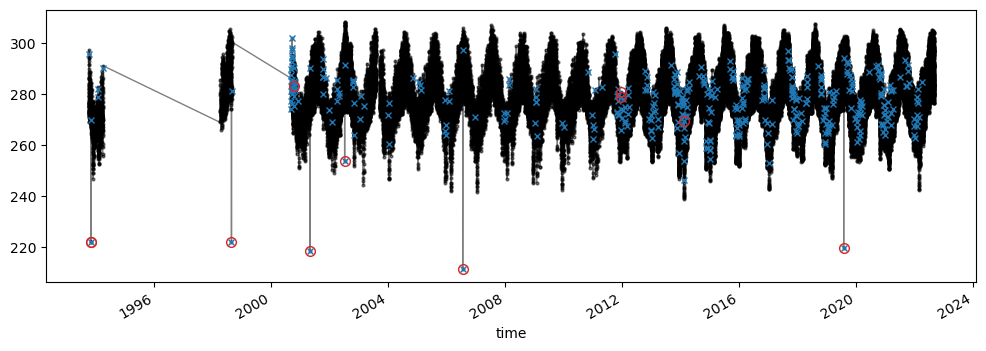

In [17]:
fig,ax = plt.subplots(figsize=(12,4))
df['difference'].plot(ax=ax, marker=".", ms=4, lw=1, label="diff", color="k", alpha=0.5)
( -1*df['critical']).plot(ax=ax, ls="-", label="diff", color="r", alpha=0.5)
(    df['critical']).plot(ax=ax, ls="-", label="diff", color="r", alpha=0.5)
df['difference'][df['potential_spike']].plot(ax=ax, marker="x", ms=5, lw=0, color="C0")
df['difference'][spikes].plot(ax=ax, marker="o", ms=7, lw=0, mfc="none", color="C3")
ax.grid()

fig,ax = plt.subplots(figsize=(12,4))
df[var].plot(ax=ax, marker=".", ms=4, lw=1, label="diff", color="k", alpha=0.5)
df[var][df['potential_spike']].plot(ax=ax, marker="x", ms=5, lw=0, color="C0")
df[var][spikes].plot(ax=ax, marker="o", ms=7, lw=0, mfc="none", color="C3")

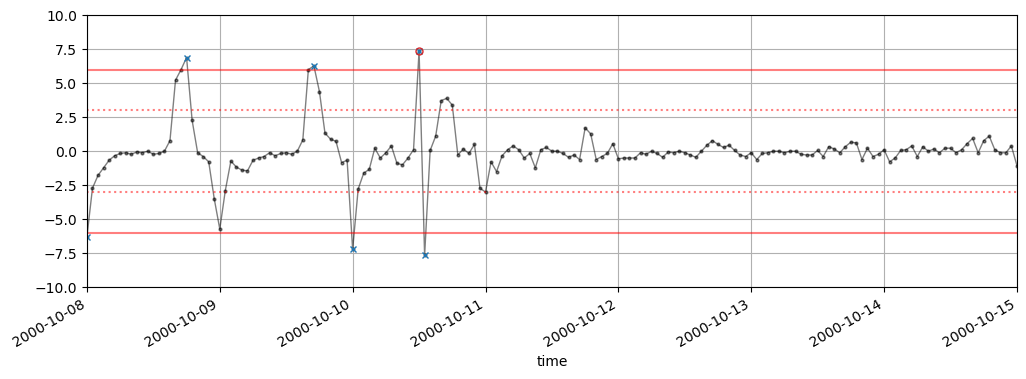

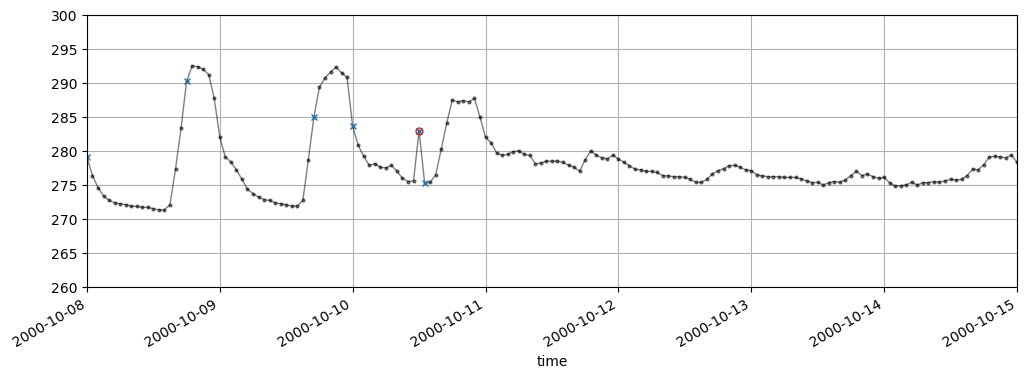

In [18]:
fig,ax = plt.subplots(figsize=(12,4))
df['difference'].plot(ax=ax, marker=".", ms=4, lw=1, label="diff", color="k", alpha=0.5)
( -1*df['critical']).plot(ax=ax, ls="-", label="diff", color="r", alpha=0.5)
(-.5*df['critical']).plot(ax=ax, ls=":", label="diff", color="r", alpha=0.5)
(    df['critical']).plot(ax=ax, ls="-", label="diff", color="r", alpha=0.5)
(0.5*df['critical']).plot(ax=ax, ls=":", label="diff", color="r", alpha=0.5)
df['difference'][df['potential_spike']].plot(ax=ax, marker="x", ms=5, lw=0, color="C0")
df['difference'][spikes].plot(ax=ax, marker="o", ms=5, lw=0, mfc="none", color="C3")
ax.set_xlim(np.datetime64("2000-10-08"), np.datetime64("2000-10-15"))
ax.set_ylim(-10,10)
ax.grid()

fig,ax = plt.subplots(figsize=(12,4))
df[var].plot(ax=ax, marker=".", ms=4, lw=1, label="diff", color="k", alpha=0.5)
df[var][df['potential_spike']].plot(ax=ax, marker="x", ms=5, lw=0, color="C0")
df[var][spikes].plot(ax=ax, marker="o", ms=5, lw=0, mfc="none", color="C3")
ax.set_xlim(np.datetime64("2000-10-08"), np.datetime64("2000-10-15"))
ax.set_ylim(260,300)
ax.grid()

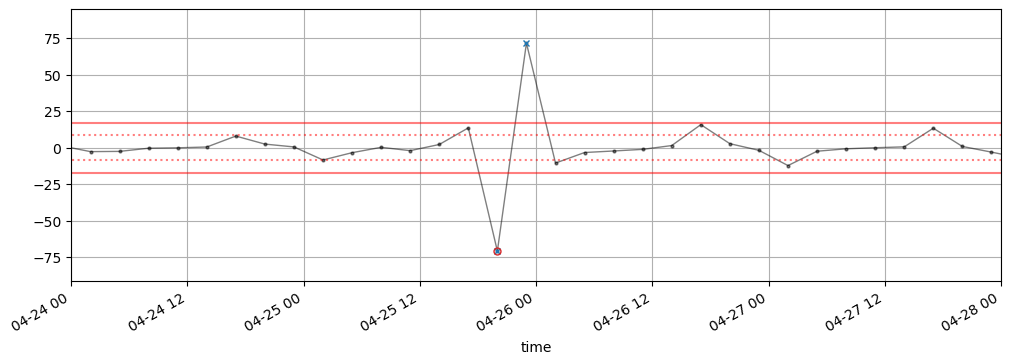

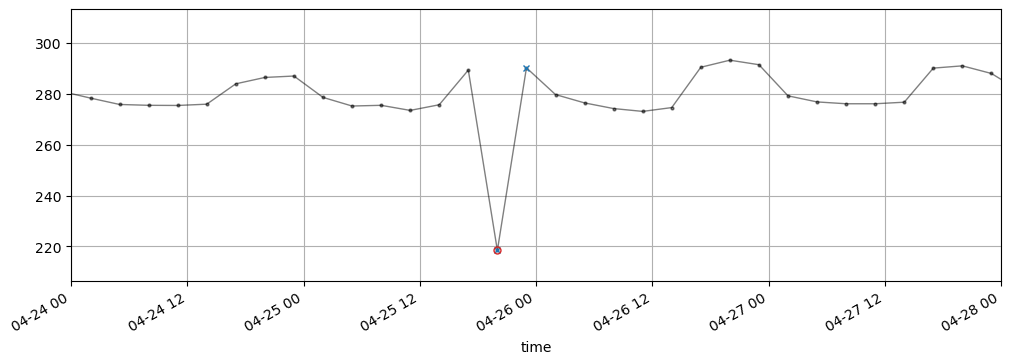

In [19]:
fig,ax = plt.subplots(figsize=(12,4))
df['difference'].plot(ax=ax, marker=".", ms=4, lw=1, label="diff", color="k", alpha=0.5)
( -1*df['critical']).plot(ax=ax, ls="-", label="diff", color="r", alpha=0.5)
(-.5*df['critical']).plot(ax=ax, ls=":", label="diff", color="r", alpha=0.5)
(    df['critical']).plot(ax=ax, ls="-", label="diff", color="r", alpha=0.5)
(0.5*df['critical']).plot(ax=ax, ls=":", label="diff", color="r", alpha=0.5)
df['difference'][df['potential_spike']].plot(ax=ax, marker="x", ms=5, lw=0, color="C0")
df['difference'][spikes].plot(ax=ax, marker="o", ms=5, lw=0, mfc="none", color="C3")
ax.set_xlim(np.datetime64("2001-04-24"), np.datetime64("2001-04-28"))
ax.grid()

fig,ax = plt.subplots(figsize=(12,4))
df[var].plot(ax=ax, marker=".", ms=4, lw=1, label="diff", color="k", alpha=0.5)
df[var][df['potential_spike']].plot(ax=ax, marker="x", ms=5, lw=0, color="C0")
df[var][spikes].plot(ax=ax, marker="o", ms=5, lw=0, mfc="none", color="C3")
ax.set_xlim(np.datetime64("2001-04-24"), np.datetime64("2001-04-28"))
ax.grid()

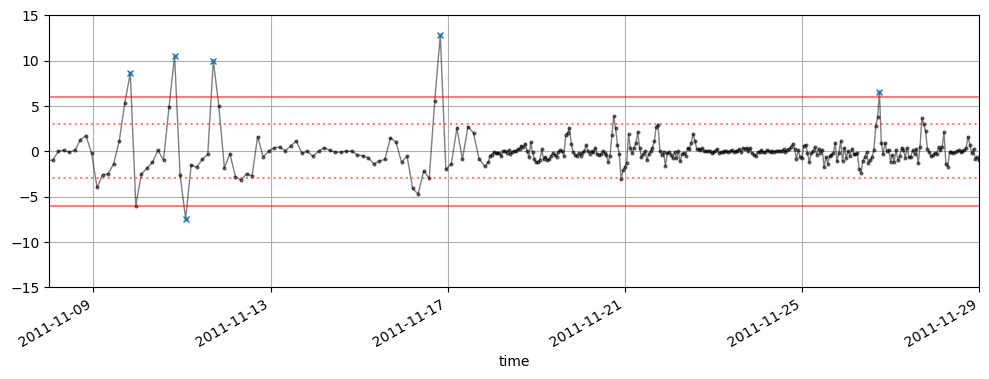

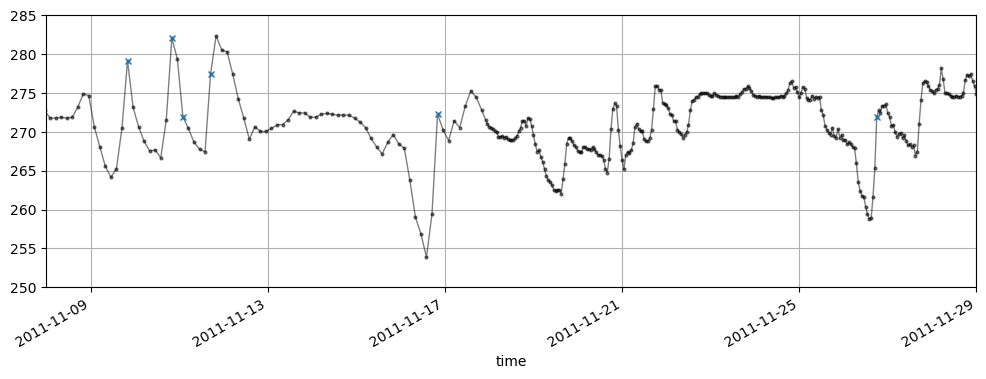

In [20]:
fig,ax = plt.subplots(figsize=(12,4))
df['difference'].plot(ax=ax, marker=".", ms=4, lw=1, label="diff", color="k", alpha=0.5)
( -1*df['critical']).plot(ax=ax, ls="-", label="diff", color="r", alpha=0.5)
(-.5*df['critical']).plot(ax=ax, ls=":", label="diff", color="r", alpha=0.5)
(    df['critical']).plot(ax=ax, ls="-", label="diff", color="r", alpha=0.5)
(0.5*df['critical']).plot(ax=ax, ls=":", label="diff", color="r", alpha=0.5)
df['difference'][df['potential_spike']].plot(ax=ax, marker="x", ms=5, lw=0, color="C0")
df['difference'][spikes].plot(ax=ax, marker="o", ms=5, lw=0, mfc="none", color="C3")
ax.set_xlim(np.datetime64("2011-11-08"), np.datetime64("2011-11-29"))
ax.set_ylim(-15,15)
ax.grid()

fig,ax = plt.subplots(figsize=(12,4))
df[var].plot(ax=ax, marker=".", ms=4, lw=1, label="diff", color="k", alpha=0.5)
df[var][df['potential_spike']].plot(ax=ax, marker="x", ms=5, lw=0, color="C0")
df[var][spikes].plot(ax=ax, marker="o", ms=5, lw=0, mfc="none", color="C3")
ax.set_xlim(np.datetime64("2011-11-08"), np.datetime64("2011-11-29"))
ax.set_ylim(250,285)
ax.grid()

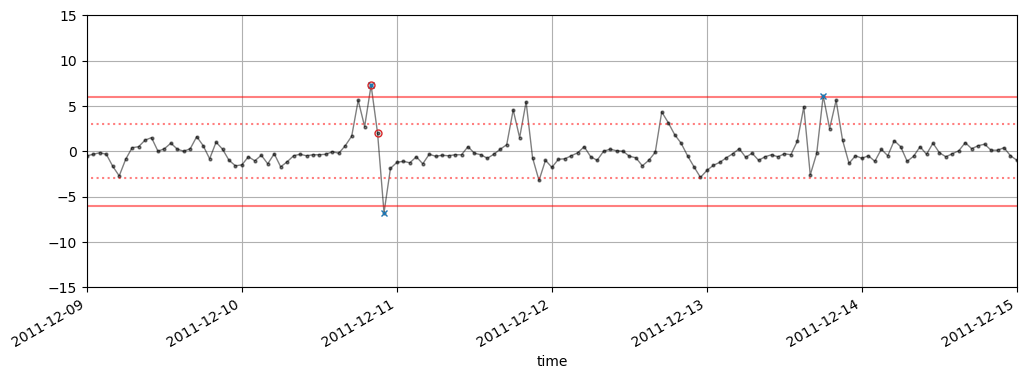

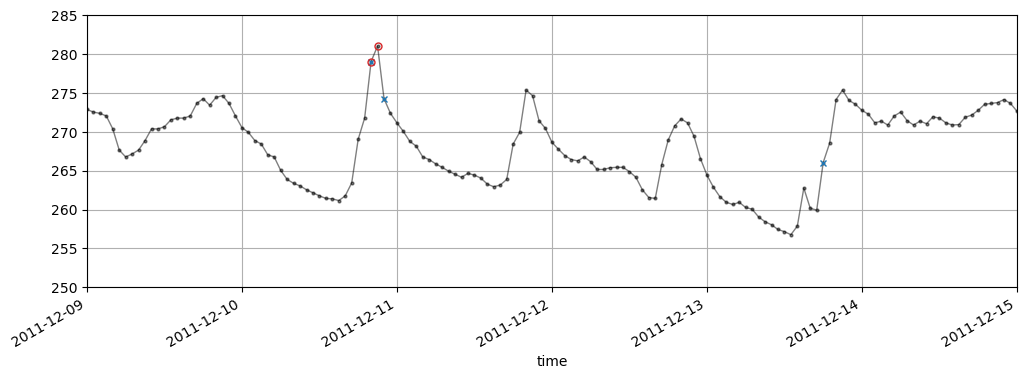

In [21]:
fig,ax = plt.subplots(figsize=(12,4))
df['difference'].plot(ax=ax, marker=".", ms=4, lw=1, label="diff", color="k", alpha=0.5)
( -1*df['critical']).plot(ax=ax, ls="-", label="diff", color="r", alpha=0.5)
(-.5*df['critical']).plot(ax=ax, ls=":", label="diff", color="r", alpha=0.5)
(    df['critical']).plot(ax=ax, ls="-", label="diff", color="r", alpha=0.5)
(0.5*df['critical']).plot(ax=ax, ls=":", label="diff", color="r", alpha=0.5)
df['difference'][df['potential_spike']].plot(ax=ax, marker="x", ms=5, lw=0, color="C0")
df['difference'][spikes].plot(ax=ax, marker="o", ms=5, lw=0, mfc="none", color="C3")
ax.set_xlim(np.datetime64("2011-12-09"), np.datetime64("2011-12-15"))
ax.set_ylim(-15,15)
ax.grid()

fig,ax = plt.subplots(figsize=(12,4))
df[var].plot(ax=ax, marker=".", ms=4, lw=1, label="diff", color="k", alpha=0.5)
df[var][df['potential_spike']].plot(ax=ax, marker="x", ms=5, lw=0, color="C0")
df[var][spikes].plot(ax=ax, marker="o", ms=5, lw=0, mfc="none", color="C3")
ax.set_xlim(np.datetime64("2011-12-09"), np.datetime64("2011-12-15"))
ax.set_ylim(250,285)
ax.grid()

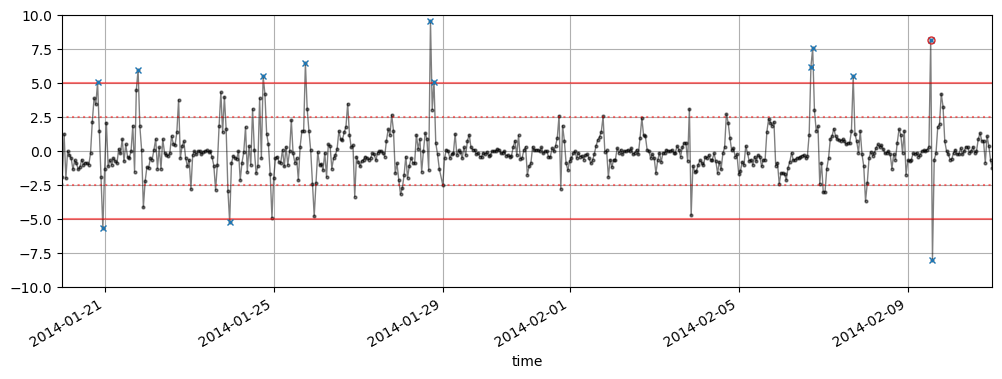

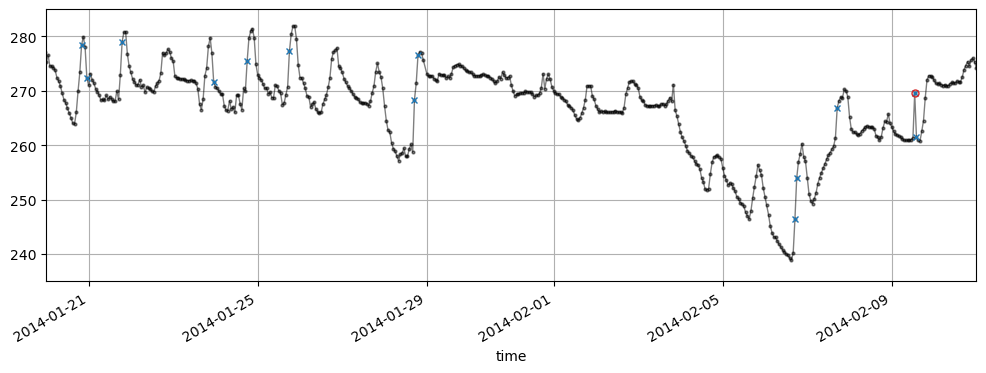

In [22]:
fig,ax = plt.subplots(figsize=(12,4))
df['difference'].plot(ax=ax, marker=".", ms=4, lw=1, label="diff", color="k", alpha=0.5)
( -1*df['critical']).plot(ax=ax, ls="-", label="diff", color="r", alpha=0.5)
(-.5*df['critical']).plot(ax=ax, ls=":", label="diff", color="r", alpha=0.5)
(    df['critical']).plot(ax=ax, ls="-", label="diff", color="r", alpha=0.5)
(0.5*df['critical']).plot(ax=ax, ls=":", label="diff", color="r", alpha=0.5)
df['difference'][df['potential_spike']].plot(ax=ax, marker="x", ms=5, lw=0, color="C0")
df['difference'][spikes].plot(ax=ax, marker="o", ms=5, lw=0, mfc="none", color="C3")
ax.set_xlim(np.datetime64("2014-01-20"), np.datetime64("2014-02-11"))
ax.set_ylim(-10,10)
ax.grid()

fig,ax = plt.subplots(figsize=(12,4))
df[var].plot(ax=ax, marker=".", ms=4, lw=1, label="diff", color="k", alpha=0.5)
df[var][df['potential_spike']].plot(ax=ax, marker="x", ms=5, lw=0, color="C0")
df[var][spikes].plot(ax=ax, marker="o", ms=5, lw=0, mfc="none", color="C3")
ax.set_xlim(np.datetime64("2014-01-20"), np.datetime64("2014-02-11"))
ax.set_ylim(235,285)
ax.grid()

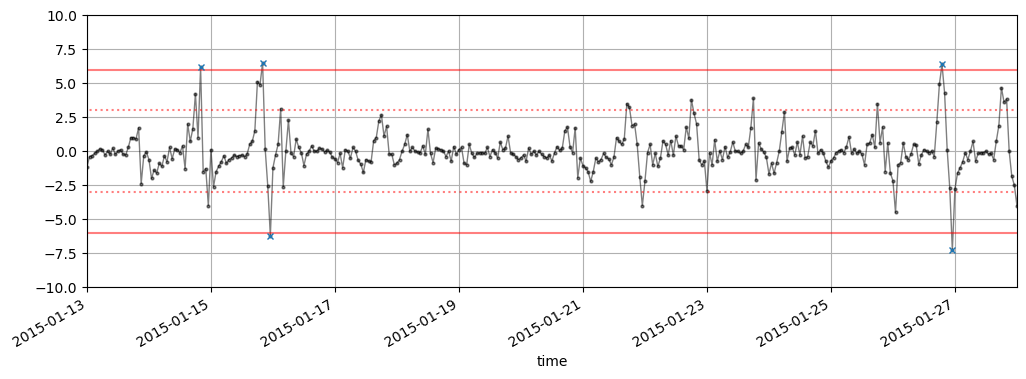

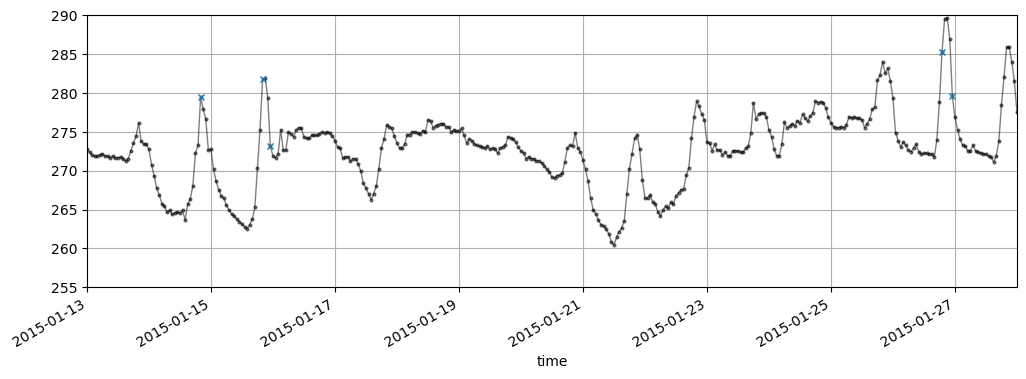

In [23]:
fig,ax = plt.subplots(figsize=(12,4))
df['difference'].plot(ax=ax, marker=".", ms=4, lw=1, label="diff", color="k", alpha=0.5)
( -1*df['critical']).plot(ax=ax, ls="-", label="diff", color="r", alpha=0.5)
(-.5*df['critical']).plot(ax=ax, ls=":", label="diff", color="r", alpha=0.5)
(    df['critical']).plot(ax=ax, ls="-", label="diff", color="r", alpha=0.5)
(0.5*df['critical']).plot(ax=ax, ls=":", label="diff", color="r", alpha=0.5)
df['difference'][df['potential_spike']].plot(ax=ax, marker="x", ms=5, lw=0, color="C0")
df['difference'][spikes].plot(ax=ax, marker="o", ms=5, lw=0, mfc="none", color="C3")
ax.set_xlim(np.datetime64("2015-01-13"), np.datetime64("2015-01-28"))
ax.set_ylim(-10,10)
ax.grid()

fig,ax = plt.subplots(figsize=(12,4))
df[var].plot(ax=ax, marker=".", ms=4, lw=1, label="diff", color="k", alpha=0.5)
df[var][df['potential_spike']].plot(ax=ax, marker="x", ms=5, lw=0, color="C0")
df[var][spikes].plot(ax=ax, marker="o", ms=5, lw=0, mfc="none", color="C3")
ax.set_xlim(np.datetime64("2015-01-13"), np.datetime64("2015-01-28"))
ax.set_ylim(255,290)
ax.grid()

### ASOSAWOS_72032204129

In [24]:
ds = xr.open_dataset('train_files/ASOSAWOS_72032204129.nc').isel(station=0)
df = ds[var].to_dataframe().dropna(subset=var).drop(columns=["lat","lon"])#.reset_index()

In [25]:
# df['abs_difference'] = np.abs(df[var].diff().fillna(0))
df['difference'] = df[var].diff().fillna(0)
# df['difference'] = (df[var]-df['y_fit']).diff().fillna(0)
df['date'] = df.index.values
df['time_diff'] = df['date'].diff().fillna(pd.Timedelta(0))
df['hours_diff'] = df['time_diff']/np.timedelta64(1, 'h')
dfbk = df.copy(deep=True)
df = df[np.logical_and(df['hours_diff'] > 0, df['hours_diff'] <= 10)]
df.head()

,station,tas,difference,date,time_diff,hours_diff
time,,,,,,
2006-01-01 00:30:00,ASOSAWOS_72032204129,276.15,0.0,2006-01-01 00:30:00,0 days 00:20:00,0.333333
2006-01-01 00:50:00,ASOSAWOS_72032204129,276.15,0.0,2006-01-01 00:50:00,0 days 00:20:00,0.333333
2006-01-01 01:10:00,ASOSAWOS_72032204129,276.15,0.0,2006-01-01 01:10:00,0 days 00:20:00,0.333333
2006-01-01 01:30:00,ASOSAWOS_72032204129,276.15,0.0,2006-01-01 01:30:00,0 days 00:20:00,0.333333
2006-01-01 01:50:00,ASOSAWOS_72032204129,276.15,0.0,2006-01-01 01:50:00,0 days 00:20:00,0.333333


<AxesSubplot:title={'center':'station = ASOSAWOS_72032204129'}, xlabel='time', ylabel='air_temperature\n[degree_Kelvin]'>

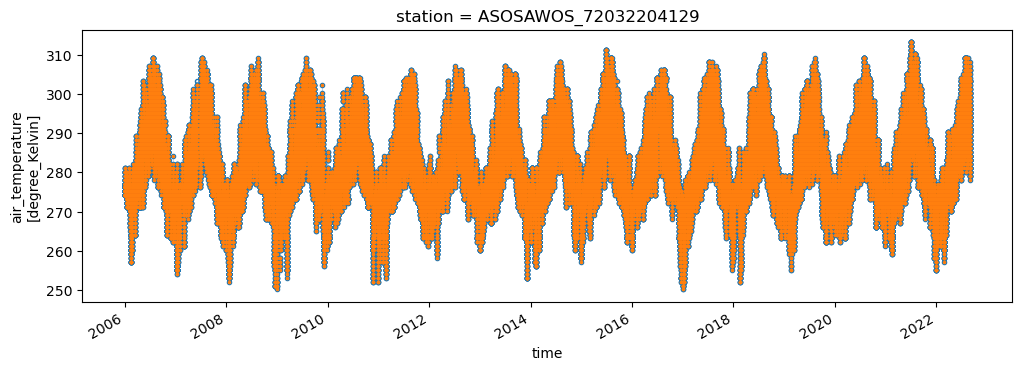

In [26]:
fig,ax = plt.subplots(figsize=(12,4))

ds[var].plot(ax=ax, marker=".", ms=6, lw=.1, mfc='none')
df[var].plot(ax=ax, marker=".", ms=3, lw=0)

In [27]:
# fig,ax = plt.subplots(figsize=(12,4))

# (df[var]).plot(ax=ax, marker=".", ms=3, lw=.1, mfc='none', color="k")
# ax.set_xlim(np.datetime64("2000-04-15"), np.datetime64("2000-06-01"))

In [28]:
# grouped = df.groupby([pd.Grouper(freq='M'), df['hours_diff']]) 
grouped = df.groupby(pd.Grouper(freq='M')) 

# grouped = df.groupby([pd.Grouper(freq='Y'), df['hours_diff']]) 
# grouped = df.groupby([pd.Grouper(freq='Y')]) 
# grouped = df.groupby([df['hours_diff']]) 

counts = grouped['difference'].transform("count")

# std = grouped['difference'].transform("median") + grouped['difference'].transform("std")

df['counts'] = counts
df = df[df['counts']>100]

# kwargs = {'rng':(15, 85),
# kwargs = {'rng':(25, 75),
#           'scale':1.0,
#           'nan_policy':'propagate',
#           'interpolation':'linear',
#          }
# kwargs = {'rng':(20, 80),}
kwargs = {}
iqr = grouped['difference'].transform(scipy.stats.iqr, **kwargs)
# abs_iqr = grouped['abs_difference'].transform(scipy.stats.iqr, **kwargs)
df['iqr'] = iqr
# df['abs_iqr'] = abs_iqr
# df['std'] = std

df['critical'] = np.ceil(6*df['iqr'])
# df['abs_critical'] = np.ceil(6*df['abs_iqr'])
df

# df.iloc[-16800:-16750]

,station,tas,difference,date,time_diff,hours_diff,counts,iqr,critical
time,,,,,,,,,
2006-01-01 00:30:00,ASOSAWOS_72032204129,276.15,0.0,2006-01-01 00:30:00,0 days 00:20:00,0.333333,2112,0.0,0.0
2006-01-01 00:50:00,ASOSAWOS_72032204129,276.15,0.0,2006-01-01 00:50:00,0 days 00:20:00,0.333333,2112,0.0,0.0
2006-01-01 01:10:00,ASOSAWOS_72032204129,276.15,0.0,2006-01-01 01:10:00,0 days 00:20:00,0.333333,2112,0.0,0.0
2006-01-01 01:30:00,ASOSAWOS_72032204129,276.15,0.0,2006-01-01 01:30:00,0 days 00:20:00,0.333333,2112,0.0,0.0
2006-01-01 01:50:00,ASOSAWOS_72032204129,276.15,0.0,2006-01-01 01:50:00,0 days 00:20:00,0.333333,2112,0.0,0.0
...,...,...,...,...,...,...,...,...,...
2022-08-31 22:35:00,ASOSAWOS_72032204129,306.15,0.0,2022-08-31 22:35:00,0 days 00:20:00,0.333333,2203,1.0,6.0
2022-08-31 22:55:00,ASOSAWOS_72032204129,307.15,1.0,2022-08-31 22:55:00,0 days 00:20:00,0.333333,2203,1.0,6.0
2022-08-31 23:15:00,ASOSAWOS_72032204129,307.15,0.0,2022-08-31 23:15:00,0 days 00:20:00,0.333333,2203,1.0,6.0


In [29]:
df['potential_spike'] = np.abs(df['difference'])>df['critical']
len(np.where(df['potential_spike'])[0])

118654

<AxesSubplot:xlabel='time'>

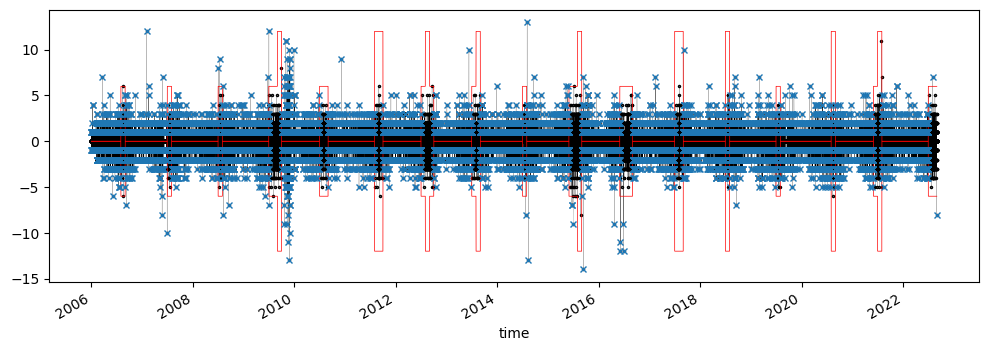

In [30]:
fig,ax = plt.subplots(figsize=(12,4))

(df['difference']).plot(ax=ax, marker=".", ms=3, lw=.1, mfc='none', color="k")
(df['critical']).plot(ax=ax, lw=.5, ls="-", color="red")
(-1*df['critical']).plot(ax=ax, lw=.5, ls="-", color="red")
df['difference'][df['potential_spike']].plot(ax=ax, marker="x", ms=5, lw=0, color="C0")

# fig,ax = plt.subplots(figsize=(12,4))

# (df['abs_difference']).plot(ax=ax, marker=".", ms=2, lw=.1, mfc='none', color="k")
# (df['abs_critical']).plot(ax=ax, lw=.5, color="red")

In [31]:
# fig,ax = plt.subplots(figsize=(12,4))

# (dfbk['difference']).plot(ax=ax, marker=".", ms=3, lw=.1, mfc='none', color="k")
# (df['critical']).plot(ax=ax, lw=.5, ls="-", color="red")
# (-1*df['critical']).plot(ax=ax, lw=.5, ls="-", color="red")
# df['difference'][df['potential_spike']].plot(ax=ax, marker="x", ms=5, lw=0, color="C0")
# ax.set_xlim(np.datetime64("2000-04-15"), np.datetime64("2000-06-01"))
# axt = ax.twinx()
# df['hours_diff'].plot(ax=axt)

In [32]:
# fig,ax = plt.subplots(figsize=(12,4))

# (dfbk['difference']).plot(ax=ax, marker=".", ms=3, lw=.1, mfc='none', color="k")
# (df['critical']).plot(ax=ax, lw=.5, ls="-", color="red")
# (-1*df['critical']).plot(ax=ax, lw=.5, ls="-", color="red")
# df['difference'][df['potential_spike']].plot(ax=ax, marker="x", ms=5, lw=0, color="C0")
# ax.set_xlim(np.datetime64("2000-04-25"), np.datetime64("2000-05-05"))
# axt = ax.twinx()
# df['hours_diff'].plot(ax=axt)

In [33]:
spikes = potential_spike_check(df['potential_spike'], df['difference'], df['critical'], df['hours_diff'])
print(len(np.where(spikes)[0]))
df['spikes'] = spikes
df.head(5)

0


,station,tas,difference,date,time_diff,hours_diff,counts,iqr,critical,potential_spike,spikes
time,,,,,,,,,,,
2006-01-01 00:30:00,ASOSAWOS_72032204129,276.15,0.0,2006-01-01 00:30:00,0 days 00:20:00,0.333333,2112,0.0,0.0,False,False
2006-01-01 00:50:00,ASOSAWOS_72032204129,276.15,0.0,2006-01-01 00:50:00,0 days 00:20:00,0.333333,2112,0.0,0.0,False,False
2006-01-01 01:10:00,ASOSAWOS_72032204129,276.15,0.0,2006-01-01 01:10:00,0 days 00:20:00,0.333333,2112,0.0,0.0,False,False
2006-01-01 01:30:00,ASOSAWOS_72032204129,276.15,0.0,2006-01-01 01:30:00,0 days 00:20:00,0.333333,2112,0.0,0.0,False,False
2006-01-01 01:50:00,ASOSAWOS_72032204129,276.15,0.0,2006-01-01 01:50:00,0 days 00:20:00,0.333333,2112,0.0,0.0,False,False


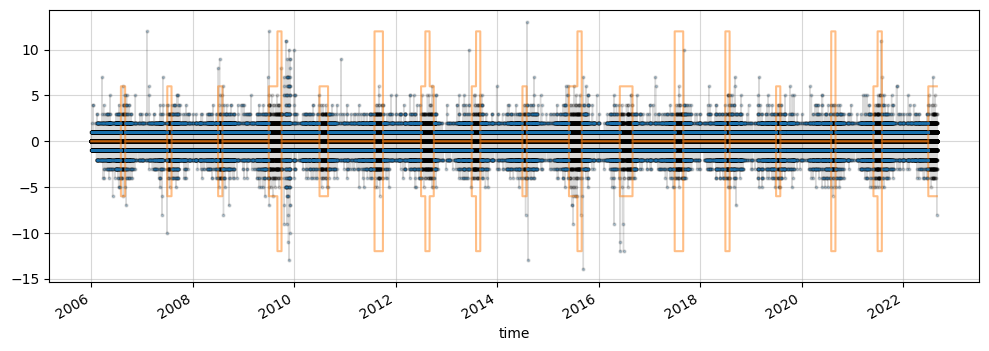

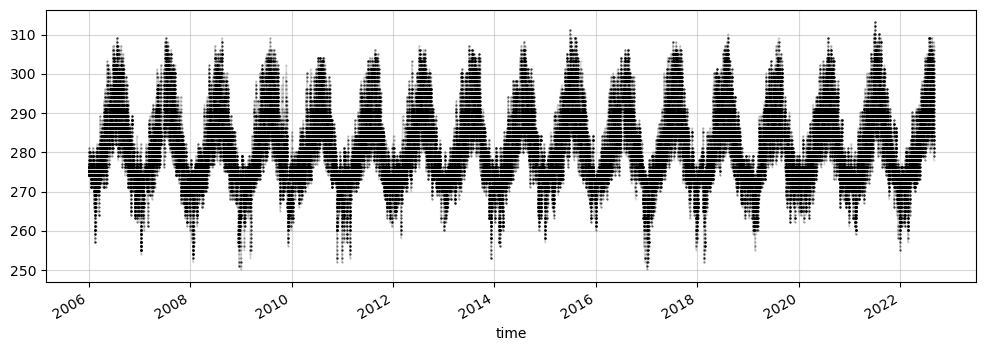

In [34]:
fig,ax = plt.subplots(figsize=(12,4))
df['difference'].plot(ax=ax, marker=".", ms=4, lw=1, label="diff", color="k", alpha=0.15)
( -1*df['critical']).plot(ax=ax, ls="-", label="diff", color="C1", alpha=0.5)
(    df['critical']).plot(ax=ax, ls="-", label="diff", color="C1", alpha=0.5)
df['difference'][df['potential_spike']].plot(ax=ax, marker=".", ms=2, lw=0, color="C0", alpha=0.15)
df['difference'][df['spikes']].plot(ax=ax, marker="o", ms=7, lw=0, mfc="none", color="C3")
ax.grid(alpha=0.5)

fig,ax = plt.subplots(figsize=(12,4))
df[var].plot(ax=ax, marker=".", ms=1, lw=1, label="diff", color="k", alpha=0.15)
df[var][df['spikes']].plot(ax=ax, marker="o", ms=7, lw=0, mfc="none", color="C3")
ax.grid(alpha=0.5)

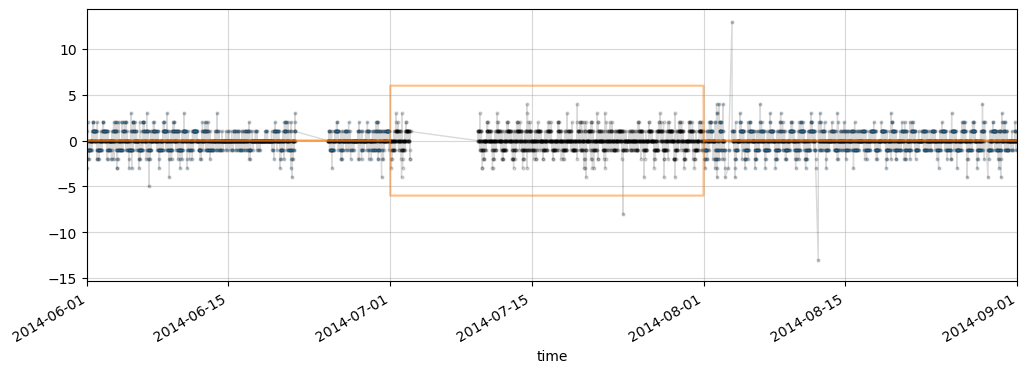

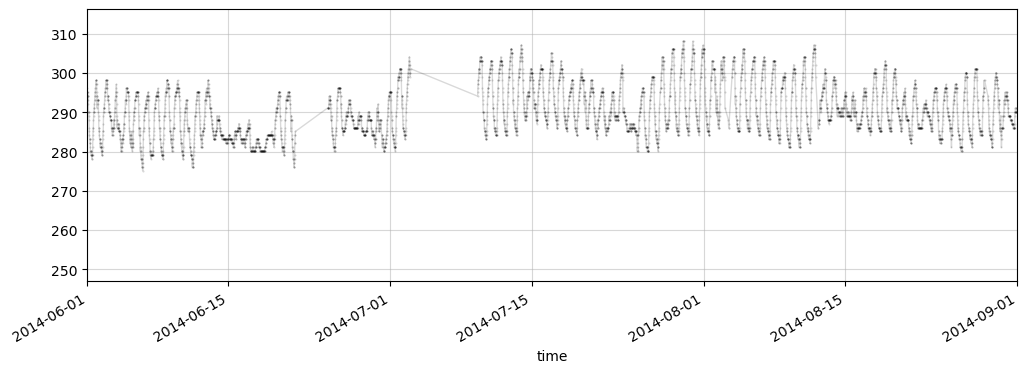

In [35]:
fig,ax = plt.subplots(figsize=(12,4))
df['difference'].plot(ax=ax, marker=".", ms=4, lw=1, label="diff", color="k", alpha=0.15)
( -1*df['critical']).plot(ax=ax, ls="-", label="diff", color="C1", alpha=0.5)
(    df['critical']).plot(ax=ax, ls="-", label="diff", color="C1", alpha=0.5)
df['difference'][df['potential_spike']].plot(ax=ax, marker=".", ms=2, lw=0, color="C0", alpha=0.15)
df['difference'][df['spikes']].plot(ax=ax, marker="o", ms=7, lw=0, mfc="none", color="C3")
ax.set_xlim(np.datetime64("2014-06-01"), np.datetime64("2014-09-01"))
ax.grid(alpha=0.5)

fig,ax = plt.subplots(figsize=(12,4))
df[var].plot(ax=ax, marker=".", ms=1, lw=1, label="diff", color="k", alpha=0.15)
df[var][df['spikes']].plot(ax=ax, marker="o", ms=7, lw=0, mfc="none", color="C3")
ax.set_xlim(np.datetime64("2014-06-01"), np.datetime64("2014-09-01"))
ax.grid(alpha=0.5)

## Tweaks

- Hourly data?
- Number of data for each month/time difference (grouping) to be valid?
- Number of IQR
- Before/after peak thresholds
- Group by time diff or not

## Detect spikes function

In [36]:
def detect_spikes(df, var):
    """
    
    """
    
    df = df.copy(deep=True)
    
    # Calculate difference in var values
    df[var+'_difference'] = df[var].diff().fillna(0)
    
    # Calculate dates
    df['date'] = df.index.values
    
    # Calculate time difference
    df['time_diff'] = df['date'].diff().fillna(pd.Timedelta(0))
    
    # Calculate time differece in hours
    df['hours_diff'] = df['time_diff']/np.timedelta64(1, 'h')
    df = df[np.logical_and(df['hours_diff'] > 0, df['hours_diff'] <= 12)]
    
    # Group by month to avoid strong seasonal cycle
    # grouped = df.groupby([pd.Grouper(freq='M'), df['hours_diff']]) 
    grouped = df.groupby(pd.Grouper(freq='M')) 

    # Count number of data per month
    counts = grouped[var+'_difference'].transform("count")
    df[var+'_counts'] = counts
    # Keep only months with more than 50 values to be statistically valid
    df = df[df[var+'_counts']>50]

    # Define modified IQR 
    # kwargs = {'rng':(20, 80),}
    kwargs = {}
    
    # Calculate iqr
    iqr = grouped[var+'_difference'].transform(scipy.stats.iqr, **kwargs)
    df[var+'_iqr'] = iqr

    # Calculate critical value as rounded-up 6 times IQR
    df[var+'_critical'] = np.ceil(6*df[var+'_iqr'])
    
    # Find potential spike values where var diff is higher than the critical value
    df[var+'_potential_spikes'] = np.abs(df[var+'_difference'])>df[var+'_critical']

    # Filter real spikes using `potential_spike_check` function
    spikes = potential_spike_check(df[var+'_potential_spikes'], df[var+'_difference'], df[var+'_critical'], df['hours_diff'])
    df[var+'_spikes'] = spikes
    
    return df

### Variable: tas

In [37]:
var = "tas"
df = ds.to_dataframe().dropna(subset=var).drop(columns=["lat","lon","elevation","station"])
df

,ps,tas,tdps,sfcWind,sfcWind_dir,qaqc_process,ps_qc,ps_altimeter,ps_altimeter_qc,psl_qc,tas_qc,tdps_qc,sfcWind_qc,sfcWind_method,sfcWind_dir_qc
time,,,,,,,,,,,,,,,
2006-01-01 00:10:00,NaN,276.15,272.15,3.1,40.0,V020,9,99090.0,1,9,1,1,1,N,1
2006-01-01 00:30:00,NaN,276.15,273.15,2.1,30.0,V020,9,99020.0,1,9,1,1,1,N,1
2006-01-01 00:50:00,91610.0,276.15,272.15,1.5,40.0,V020,5,99020.0,5,9,C,C,5,N,5
2006-01-01 01:10:00,NaN,276.15,272.15,0.0,NaN,V020,9,99020.0,1,9,1,1,1,C,9
2006-01-01 01:30:00,NaN,276.15,273.15,0.0,NaN,V020,9,99020.0,1,9,1,1,1,C,9
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-08-31 22:35:00,93830.0,306.15,282.15,1.5,100.0,V020,5,101390.0,5,9,5,5,5,N,5
2022-08-31 22:55:00,NaN,307.15,282.15,2.1,110.0,V020,9,101320.0,1,9,1,1,1,N,1
2022-08-31 23:15:00,NaN,307.15,282.15,2.1,110.0,V020,9,101320.0,1,9,1,1,1,N,1


In [38]:
new_df = detect_spikes(df, var=var)
len(df), len(new_df)

(426647, 426582)

<AxesSubplot:xlabel='time'>

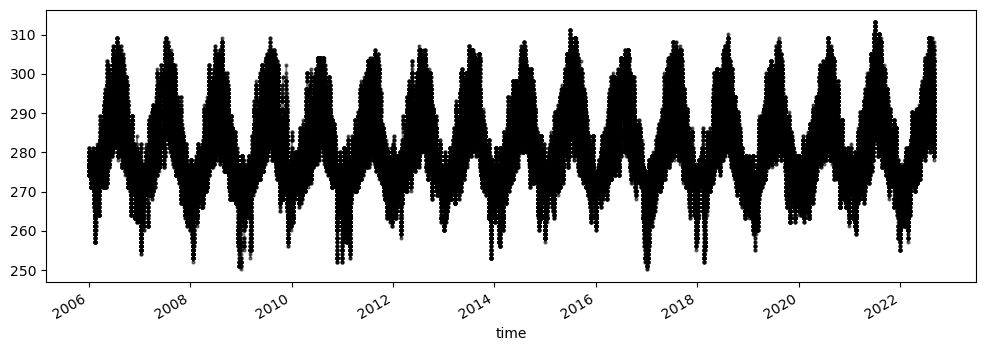

In [39]:
fig,ax = plt.subplots(figsize=(12,4))

new_df[var].plot(ax=ax, marker=".", ms=4, lw=1, label="diff", color="k", alpha=0.5)
# new_df[var][new_df[var+'_potential_spikes']].plot(ax=ax, marker="x", ms=5, lw=0, color="C0")
new_df[var][new_df[var+"_spikes"]].plot(ax=ax, marker="o", ms=7, lw=0, mfc="none", color="C3")

In [40]:
ind = new_df.index[np.where(new_df[var+"_spikes"])[0]]
ind

DatetimeIndex([], dtype='datetime64[ns]', name='time', freq=None)

<AxesSubplot:xlabel='time'>

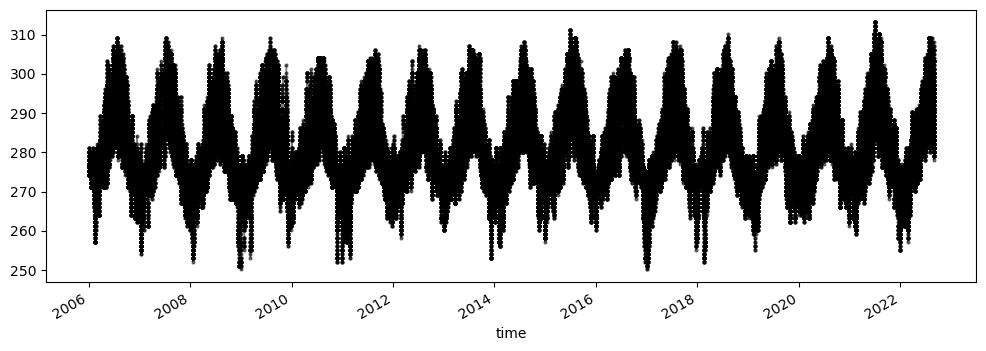

In [41]:
fig,ax = plt.subplots(figsize=(12,4))

df[var].plot(ax=ax, marker=".", ms=4, lw=1, label="diff", color="k", alpha=0.5)
df.loc[ind, var].plot(ax=ax, marker="o", ms=7, lw=0, mfc="none", color="C3")
new_df[var][new_df[var+"_spikes"]].plot(ax=ax, marker="o", ms=7, lw=0, mfc="none", color="C3")

### Variable: tdps

In [42]:
var = "tdps"
var = "tas"
ds = xr.open_dataset('train_files/ASOSAWOS_72032204129.nc').isel(station=0)
df = ds.to_dataframe().dropna(subset=var).drop(columns=["lat","lon","elevation","station"])
df.head(5)

,ps,tas,tdps,sfcWind,sfcWind_dir,qaqc_process,ps_qc,ps_altimeter,ps_altimeter_qc,psl_qc,tas_qc,tdps_qc,sfcWind_qc,sfcWind_method,sfcWind_dir_qc
time,,,,,,,,,,,,,,,
2006-01-01 00:10:00,NaN,276.15,272.15,3.1,40.0,V020,9,99090.0,1,9,1,1,1,N,1
2006-01-01 00:30:00,NaN,276.15,273.15,2.1,30.0,V020,9,99020.0,1,9,1,1,1,N,1
2006-01-01 00:50:00,91610.0,276.15,272.15,1.5,40.0,V020,5,99020.0,5,9,C,C,5,N,5
2006-01-01 01:10:00,NaN,276.15,272.15,0.0,NaN,V020,9,99020.0,1,9,1,1,1,C,9
2006-01-01 01:30:00,NaN,276.15,273.15,0.0,NaN,V020,9,99020.0,1,9,1,1,1,C,9


In [43]:
new_df = detect_spikes(df, var=var)
drop_vars = ["qaqc_process","ps_qc","ps_altimeter_qc","sfcWind_qc","sfcWind_dir_qc","psl_qc","tas_qc","sfcWind_method","tdps_qc"]
new_df.drop(columns=drop_vars).head(5)
len(df), len(new_df)

(426647, 426582)

In [44]:
pd.Series(df.index.values).diff()

0                    NaT
1        0 days 00:20:00
2        0 days 00:20:00
3        0 days 00:20:00
4        0 days 00:20:00
               ...      
426642   0 days 00:20:00
426643   0 days 00:20:00
426644   0 days 00:20:00
426645   0 days 00:20:00
426646   0 days 00:20:00
Length: 426647, dtype: timedelta64[ns]

<AxesSubplot:xlabel='time'>

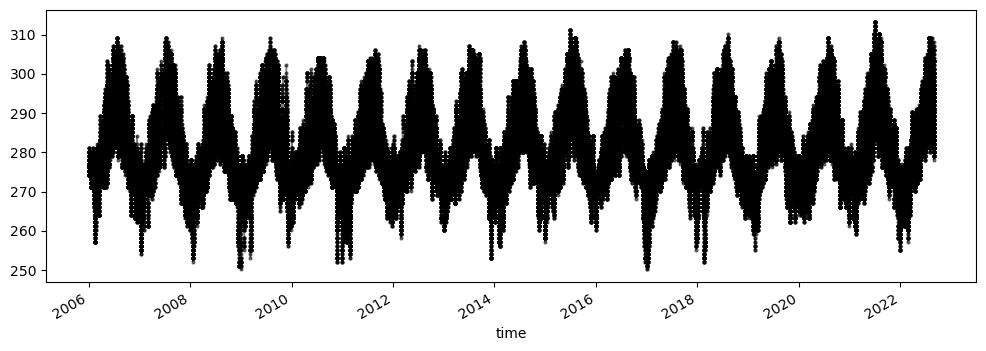

In [45]:
fig,ax = plt.subplots(figsize=(12,4))

df[var].plot(ax=ax, marker=".", ms=4, lw=1, label="diff", color="k", alpha=0.5)
# new_df[var][new_df[var+'_potential_spikes']].plot(ax=ax, marker="x", ms=5, lw=0, color="C0")
# new_df[var][new_df[var+"_spikes"]].plot(ax=ax, marker="o", ms=7, lw=0, mfc="none", color="C3")

## Unusual Large Jumps Function

In [46]:
# def run_qaqc_pipeline(ds, network, file_name, 
#                       errors, station, end_api, 
#                       verbose=True):
def xarray_to_pandas_qaqc(ds):
    """
    """

    ## Add qc_flag variable for all variables, including elevation; 
    ## defaulting to nan for fill value that will be replaced with qc flag
    exclude_qaqc = ["time", "station", "lat", "lon", 
                    "qaqc_process", "sfcWind_method"] # lat and lon have a different qc check

    raw_qc_vars = [] # qc_variable for each data variable, will vary station to station
    era_qc_vars = [] # our qc variable
    for var in ds.data_vars:
        if 'q_code' in var:
            raw_qc_vars.append(var) # raw qc variable, need to keep for comparison, then drop
        if '_qc' in var:
            raw_qc_vars.append(var) # raw qc variables, need to keep for comparison, then drop

    for var in ds.data_vars:
        if var not in exclude_qaqc and var not in raw_qc_vars:
            qc_var = var + "_eraqc" # variable/column label
            era_qc_vars.append(qc_var)
            # adds new variable in shape of original variable with designated nan fill value
            ds = ds.assign({qc_var: xr.ones_like(ds[var])*np.nan})

    # Save attributes to inheret them to the QAQC'ed file
    attrs = ds.attrs
    var_attrs = {var:ds[var].attrs for var in list(ds.data_vars.keys())}

    df = ds.to_dataframe()
    df['anemometer_height_m'] = np.ones(ds['time'].shape)*ds.anemometer_height_m
    df['thermometer_height_m'] = np.ones(ds['time'].shape)*ds.thermometer_height_m
    
    return df

In [47]:
def qaqc_world_record(df, verbose=True):
    '''
    Checks if temperature, dewpoint, windspeed, or sea level pressure are outside North American world records
    If outside minimum or maximum records, flags values
    '''
    try:
        # world records from HadISD protocol, cross-checked with WMO database
        # https://wmo.asu.edu/content/world-meteorological-organization-global-weather-climate-extremes-archive
        T_X = {"North_America":329.92} #K
        T_N = {"North_America":210.15} #K
        D_X = {"North_America":329.85} #K
        D_N = {"North_America":173.15} #K
        W_X = {"North_America":113.2} #m/s
        W_N = {"North_America":0.} #m/s
        S_X = {"North_America":108330} #Pa
        S_N = {"North_America":87000} #Pa

        maxes = {"tas": T_X, "tdps": D_X, "tdps_derived": D_X, "sfcWind": W_X, "psl": S_X}
        mins = {"tas": T_N, "tdps": D_N, "tdps_derived": D_N, "sfcWind": W_N, "psl": S_N}

        # variable names to check against world record limits
        wr_vars = ['tas', 'tdps_derived', 'tdps', 'sfcWind', 'psl']

        for var in wr_vars:
            if var in list(df.columns):
                isOffRecord = np.logical_or(df[var] < mins[var]['North_America'],
                                            df[var] > maxes[var]['North_America'])
                if isOffRecord.any():
                    df.loc[isOffRecord, var + '_eraqc'] = 11
        return df
    except Exception as e:
        if verbose:
            print("qaqc_world_record failed with Exception: {}".format(e))
        return None

In [48]:
def unusual_large_jumps(df):
    """
    
    Flag meaninig:
        22,qaqc_unusual_large_jumps,Unusual jump (spike) in variable
    """
    
    check_vars = ["tas", "tdps", "ps", "slp"]
    variables = [var for var in check_vars if var in df.columns]
    
    for var in variables:
        new_df = df.copy(deep=True)
        new_df = new_df.dropna(subset=var).drop(columns=["lat","lon","elevation","station"])
        valid = np.where(np.isnan(new_df[var+"_eraqc"]))[0]
        new_df = new_df.iloc[valid]
        new_df = detect_spikes(new_df, var=var)
        ind = new_df.index[np.where(new_df[var+"_spikes"])[0]]      
        df.loc[ind, var+"_eraqc"] = 22
        
    return df

### SNOTEL_835

In [49]:
ds = xr.open_dataset('train_files/SNOTEL_835.nc').isel(station=0)
df = ds.to_dataframe().dropna(subset=var)
df = xarray_to_pandas_qaqc(ds)
df.head(5)

,tas,pr,tas_qc,pr_qc,elevation,station,lat,lon,tas_eraqc,pr_eraqc,elevation_eraqc,anemometer_height_m,thermometer_height_m
time,,,,,,,,,,,,,
1980-01-01 08:00:00,NaN,317.50,nan,E,1706.88,SNOTEL_835,46.14287,-114.44755,NaN,NaN,NaN,1.5,NaN
1980-01-02 08:00:00,NaN,317.50,nan,E,1706.88,SNOTEL_835,46.14287,-114.44755,NaN,NaN,NaN,1.5,NaN
1980-01-03 08:00:00,NaN,317.50,nan,E,1706.88,SNOTEL_835,46.14287,-114.44755,NaN,NaN,NaN,1.5,NaN
1980-01-04 08:00:00,NaN,320.04,nan,E,1706.88,SNOTEL_835,46.14287,-114.44755,NaN,NaN,NaN,1.5,NaN
1980-01-04 12:00:00,258.761111,320.04,V,E,1706.88,SNOTEL_835,46.14287,-114.44755,NaN,NaN,NaN,1.5,NaN


In [50]:
new_df = qaqc_world_record(df)
np.where(~np.isnan(new_df.tas_eraqc))

(array([], dtype=int64),)

In [51]:
new_df = unusual_large_jumps(new_df)
np.where(~np.isnan(new_df.tas_eraqc))

(array([ 12202,  12203,  17333,  19372,  21418,  26064,  39844,  55988,
         55989,  74987, 122887]),)

<AxesSubplot:xlabel='time'>

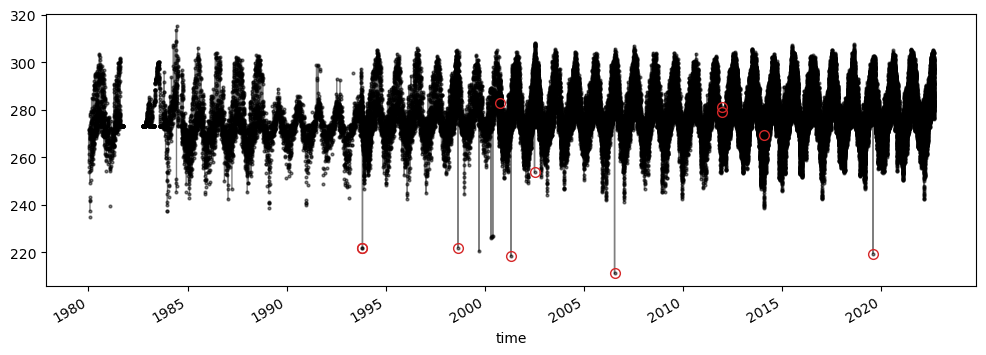

In [52]:
fig,ax = plt.subplots(figsize=(12,4))

var = "tas"
# ind = np.where()

new_df[var].plot(ax=ax, marker=".", ms=4, lw=1, label="diff", color="k", alpha=0.5)
new_df.loc[df[var+"_eraqc"]==22, var].plot(ax=ax, marker="o", ms=7, lw=0, mfc="none", color="C3")
# new_df[var][new_df[var+"_spikes"]].plot(ax=ax, marker="o", ms=7, lw=0, mfc="none", color="C3")

### RAWS_TOGC1

In [53]:
check_vars = ["tas", "tdps", "ps", "slp"]

In [54]:
ds = xr.open_dataset('train_files/RAWS_TOGC1.nc').isel(station=0)
print([var for var in list(ds.data_vars) if var in check_vars])
df = xarray_to_pandas_qaqc(ds)
new_df = qaqc_world_record(df)
print(len(np.where(~np.isnan(new_df.tas_eraqc))[0]))
new_df = unusual_large_jumps(new_df)
print(len(np.where(~np.isnan(new_df.tas_eraqc))[0]))

['tas']
0
1


<AxesSubplot:xlabel='time'>

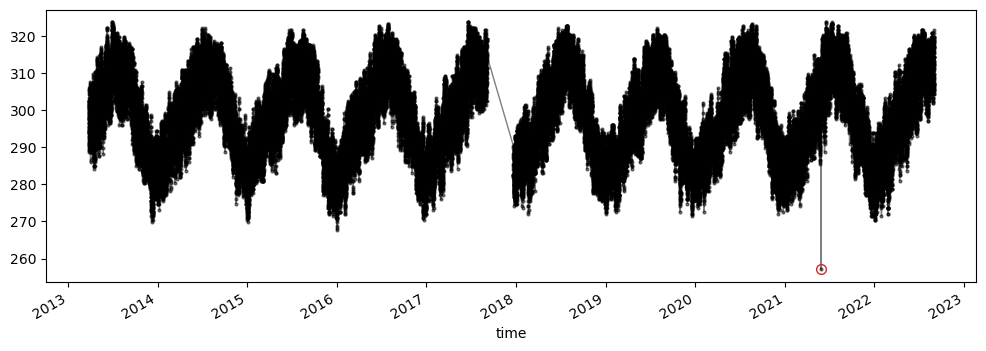

In [55]:
fig,ax = plt.subplots(figsize=(12,4))

var = "tas"
new_df[var].plot(ax=ax, marker=".", ms=4, lw=1, label="diff", color="k", alpha=0.5)
new_df.loc[df[var+"_eraqc"]==22, var].plot(ax=ax, marker="o", ms=7, lw=0, mfc="none", color="C3")

### ASOSAWOS_72032204129

In [56]:
ds = xr.open_dataset('train_files/ASOSAWOS_72032204129.nc').isel(station=0)
print([var for var in list(ds.data_vars) if var in check_vars])
df = xarray_to_pandas_qaqc(ds)
new_df = qaqc_world_record(df)
print(len(np.where(~np.isnan(new_df.tas_eraqc))[0]))
new_df = unusual_large_jumps(new_df)
print(len(np.where(~np.isnan(new_df.tas_eraqc))[0]))

['ps', 'tas', 'tdps']
0
0


<AxesSubplot:xlabel='time'>

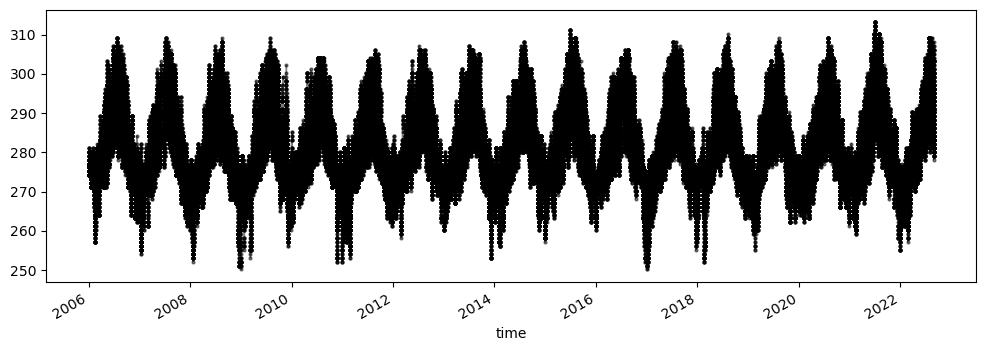

In [57]:
fig,ax = plt.subplots(figsize=(12,4))

var = "tas"
new_df[var].plot(ax=ax, marker=".", ms=4, lw=1, label="diff", color="k", alpha=0.5)
new_df.loc[df[var+"_eraqc"]==22, var].plot(ax=ax, marker="o", ms=7, lw=0, mfc="none", color="C3")

<AxesSubplot:xlabel='time'>

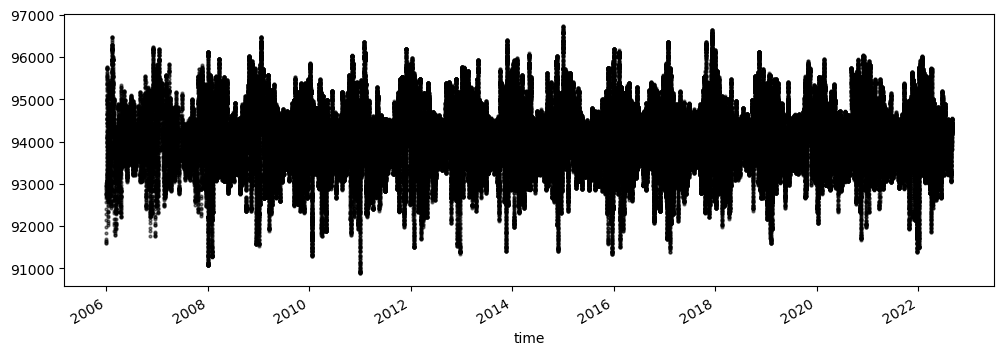

In [58]:
fig,ax = plt.subplots(figsize=(12,4))

var = "ps"
new_df[var].plot(ax=ax, marker=".", ms=4, lw=1, label="diff", color="k", alpha=0.5)
new_df.loc[df[var+"_eraqc"]==22, var].plot(ax=ax, marker="o", ms=7, lw=0, mfc="none", color="C3")

<AxesSubplot:xlabel='time'>

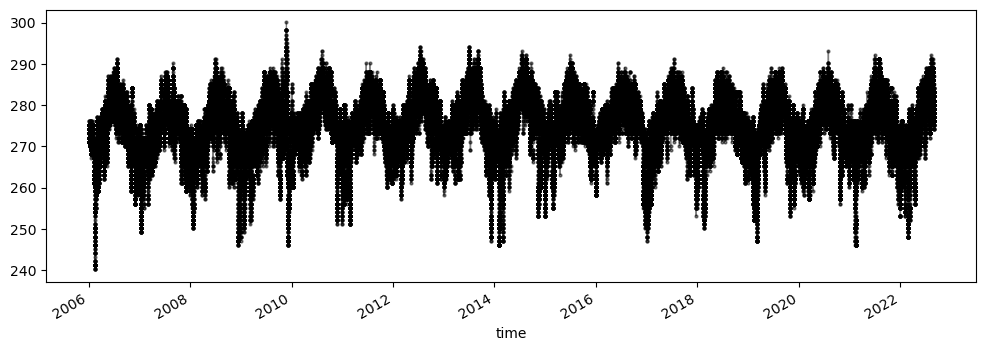

In [59]:
fig,ax = plt.subplots(figsize=(12,4))

var = "tdps"
new_df[var].plot(ax=ax, marker=".", ms=4, lw=1, label="diff", color="k", alpha=0.5)
new_df.loc[df[var+"_eraqc"]==22, var].plot(ax=ax, marker="o", ms=7, lw=0, mfc="none", color="C3")

## Takeaway points:

- It is crucial to apply other QAQC functions beforehand, otherwise this algorithm fails.
- It could be much more consistent and robust if data were in hourly format
- Is it worth it to do make data hourly at some point before this during the QAQC pipeline?